In [27]:
import numpy as np
import quadpy as qp
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import fsolve
from scipy.optimize import minimize
from scipy.optimize import fminbound
from scipy.stats import norm
from scipy.linalg import cholesky
import time

matplotlib.rcParams['text.usetex'] = True


**Model**
$$
Y_{ti} = V_{ti} U_{ti} + \sigma_t Z_{ti}, \quad t=1,\dots,T \quad i = 1, \dots, N_t
$$
$N$: total number of data points <br>
$D$: dimension of each data point <br>
$T$: number of task <br>
$N_t$: number of data points in task $t$ <br>
$C$: matrix of correlation between tasks <br>
$V_{ti} \stackrel{i.i.d}{\sim} \text{Unif}(\pm 1) $ <br>
$\{U_t\}_{t=1}^T$ are sample uniformly from the unit sphere $S^{D-1}$, conditioned on $ \langle U_s, U_t \rangle = C_{st} $ <br>
$\eta_t$: proportion of labeled data in task $ t$ <br>
$\alpha_t = N_t/D$: sampling ratio of task $t$ <br>
$\lambda_t=1/\sigma_t^2$: signal-to-noise ratio of task $t$ <br>
$\mathcal D$: all the available information, including the dataset $Y$, the labels and model parameters <br>


**Main result.** Let $\hat U_t = \mathbb E[U_t|\mathcal D]$ and $\hat{V}_t = \mathbb E[V_t|\mathcal D]$ and
$$
q_{ut} = \lim_{D \rightarrow \infty} \frac{1}{\sigma_t^2} \lVert \hat U_t \rVert^2 \in [0, \text{snr}_t] \\
q_{vt} = \lim_{N_t \rightarrow \infty} \frac{1}{N_t} \lVert \hat V_t \rVert^2 \in [0, 1]
$$
The paper shows that
$$
q_{ut} = [M - M(I+D M)^{-1}]_{tt} \\
q_{vt} = \eta_t + (1-\eta_t)F(q_{ut})
$$
where
$$
D = diag[\alpha_1 q_{v1}, \dots, \alpha_T q_{vT}]\\
F(q) = \mathbb E[\tanh(\sqrt q Z + q)], \quad Z \sim \mathcal N(0,1)
$$
The Bayes risk is given by
$$
\mathbb P(Z > \sqrt{q_{ut}})
$$



In [233]:
def inv(A):
    return np.linalg.inv(A)

# Generate a random correlation matrix C with diagonal 1
def randC(T):
    S = np.array([normalize(np.random.normal(0,1,T)) for t in range(T)])
    return S@S.T

# Generate unit vectors U_1 ... U_T in R^D with given correlations C
def randU(C,D):
    Z = np.array([np.random.normal(0,1,D) for t in range(len(C))])
    Q = np.linalg.qr(Z.T)[0].T # Q[1],...,Q[T] are orthogonal vectors in R^D
    va, ve = np.linalg.eig(C)
    va = np.diag(np.sqrt(va))
    sqrtC = ve@va@ve.T
    return sqrtC@Q

def gU(C,D):
    Z = np.array([np.random.normal(0,1,D)/np.sqrt(D) for t in range(len(C))])
    va, ve = np.linalg.eig(C)
    va = np.diag(np.sqrt(va))
    sqrtC = ve@va@ve.T
    return sqrtC@Z
    


# compute E[f(Z)] where Z ~ N(0,1) using Gauss-Hermite quadrature
scheme = qp.e1r2.gauss_hermite(7) # defining the scheme once for all. this will reduce the computation time.
def EZ(f): 
    return 1/np.sqrt(np.pi)*scheme.integrate(lambda z: f(z*np.sqrt(2)))[0]


def F(q):
    return EZ(lambda z: np.tanh(np.sqrt(q)*z + q))


def solve(eta, al, snr, C):
    eta = np.array(eta)
    al = np.array(al)
    snr = np.array(snr)
    C = np.array(C)
    T = len(eta)
    def eqs(arg):
        qv = arg[:T]
        qu = arg[T:]
        I = np.identity(T)
        D = np.diag(al*qv**2)
        Ds= np.diag(np.sqrt(snr))
        M = Ds@C@Ds
        Q = M - M@inv(I+D@M)
        eq1 = np.array([qv[i]**2-eta[i]-(1-eta[i])*F(qu[i]**2) for i in range(T)])
        eq2 = np.array([qu[i]**2-Q[i,i] for  i in range(T)])
        return np.concatenate((eq1, eq2))
    init = np.concatenate((np.ones(T), np.sqrt(snr)))
    return fsolve(eqs, init)**2

def solve2(eta, al, snr, C, init):
    eta = np.array(eta)
    al = np.array(al)
    snr = np.array(snr)
    C = np.array(C)
    T = len(eta)
    def eqs(arg):
        qv = arg[:T]
        qu = arg[T:]
        I = np.identity(T)
        D = np.diag(al*qv**2)
        Ds= np.diag(np.sqrt(snr))
        M = Ds@C@Ds
        Q = M - M@inv(I+D@M)
        eq1 = np.array([qv[i]**2-eta[i]-(1-eta[i])*F(qu[i]**2) for i in range(T)])
        eq2 = np.array([qu[i]**2-Q[i,i] for  i in range(T)])
        return np.concatenate((eq1, eq2))
    return fsolve(eqs, np.sqrt(init))**2

def R(q):
    return 1-norm.cdf(np.sqrt(q))

def under(eta, al, snr, C): # return true if the performance is trivial
    T = len(snr)
    sol = solve(eta, al, snr, C)
    q = sol[T:]/snr
    return (q[0]<0.0001)


In [236]:
np.concatenate((np.ones(4), np.ones(3)))

array([1., 1., 1., 1., 1., 1., 1.])

In [250]:
eta = [0,0,0]
al = [1.1,1,1]
snr = [1,0.5,0.5]
c = 0.5
# init = np.array([1,1,0.01,1,.1,0.01])
c12 = np.sqrt(c)
c23 = np.sqrt(1-c)
C = np.array([[1, c12, 0],[c12, 1, c23],[0, c23, 1]])
solve(eta, al, snr, C)[3:]

array([0.0846843 , 0.02614922, 0.00417156])

In [3]:
# source 
al1=1
snr1=2
eta1=1
# target 
al2=1
snr2s = np.linspace(0,3,100)
eta2s = np.linspace(0,1,100)
SNR2,ETA2 = np.meshgrid(snr2s, eta2s)

def risk2(snr2,eta2): # compute Bayes risk of task 2
    overlaps = solve([eta1,eta2], [al1,al2], [snr1, snr2], C)
    q2 = overlaps[3]
    return R(q2)

c = 0
C = np.array([[1,c],[c,1]])     
vrisk2 = np.vectorize(risk2)
risk2s0 = vrisk2(SNR2, ETA2)

c = 0.8
C = np.array([[1,c],[c,1]])     
vrisk2 = np.vectorize(risk2)
risk2s1 = vrisk2(SNR2, ETA2)


/home/toan/.myenv/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


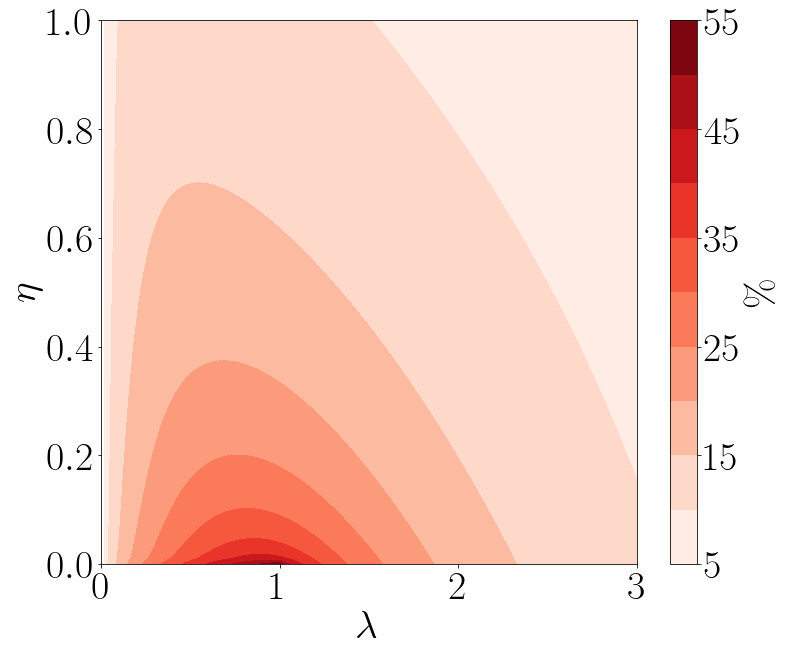

In [12]:
width = 12
height = 10
big = int(width/15*50)
small = int(0.8*big)
fig, ax = plt.subplots(figsize=(width,height))
improve = 100*(risk2s0 - risk2s1)/risk2s0
# levels = np.linspace(5,45,9)
levels = np.linspace(5,55,11)
cf = ax.contourf(SNR2, ETA2, improve, levels=levels, cmap='Reds')
ax.set_xlabel('$\lambda$', fontsize=big)
ax.set_ylabel('$\eta$', fontsize=big)
ax.tick_params(axis='both', labelsize=big)
fig.colorbar(cf, ax=ax)


import matplotlib.ticker as mtick
ax.figure.axes[1].tick_params(axis="y", labelsize=big)
ax.figure.axes[1].set_ylabel('$\%$', fontsize=big)

plt.savefig('improve.pdf')
# plt.show()

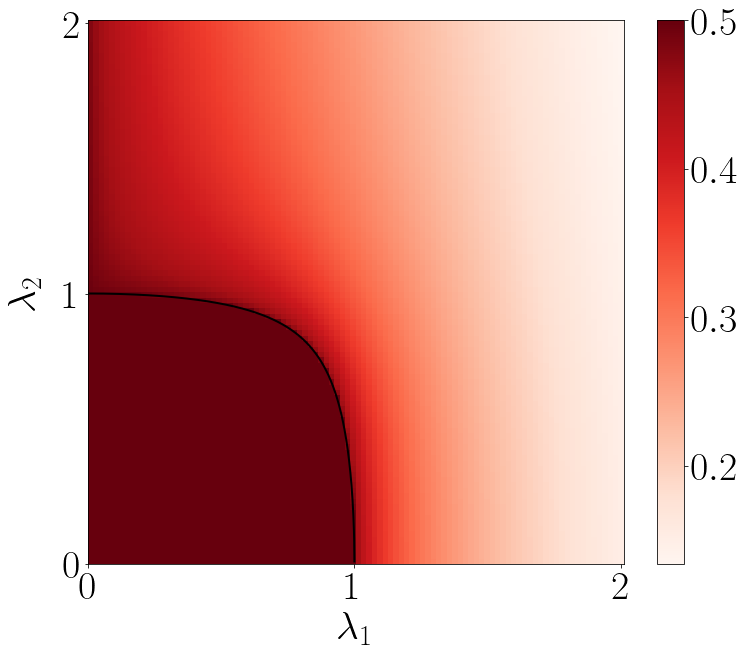

In [34]:
rho1, rho2 = 0.5, 0.5
# 1 
al1=1
snr1s=np.linspace(0.01,2,100)
eta1=0
# 2 
al2=1
snr2s = np.linspace(0.01,2,100)
eta2 = 0
SNR1,SNR2 = np.meshgrid(snr1s, snr2s)

def risk1(snr1,snr2): # compute Bayes risk of task 1
    overlaps = solve([eta1,eta2], [al1,al2], [snr1, snr2], C)
    q1 = overlaps[2]
    return R(q1)


c = 0.7
C = np.array([[1,c],[c,1]])     
vrisk1 = np.vectorize(risk1)
risk1s = vrisk1(SNR1, SNR2)


def curve(x):
    return 1/np.sqrt(1+c**4/(1/x**2-1))

width = 12
height = 10
big = int(width/15*50)
small = int(0.8*big)
fig, ax = plt.subplots(figsize=(width,height))
matplotlib.pyplot.locator_params(nbins=3)
im = ax.pcolormesh(SNR1, SNR2, risk1s, shading='auto',linewidth=0,rasterized=True, cmap='Reds')
ax.set_xlabel('$\lambda_1$', fontsize=big)
ax.set_ylabel('$\lambda_2$', labelpad=20, fontsize=big)
ax.tick_params(axis='both', labelsize=big)
cbar = plt.colorbar(im)

# import matplotlib.ticker as mtick
im.figure.axes[1].tick_params(axis="y", labelsize=big)

# draw the curve
x = np.linspace(0.001,0.99999,1000)
y=curve(x)
plt.plot(x,y,color='black', linewidth=2)

plt.savefig('phase.pdf')

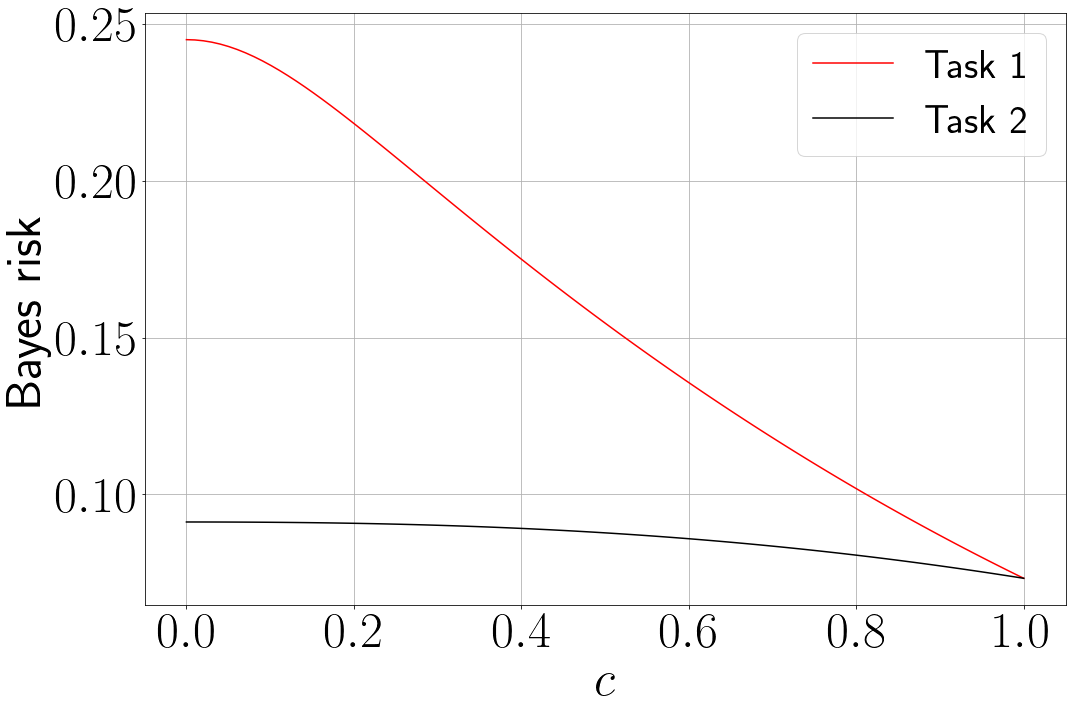

In [25]:
width = 15
height = 10
big = int(width/15*50) # if width of the figure is 15, then fontsize 50 is the right choice
small = int(0.8*big) # small font
fig, ax = plt.subplots(figsize=(width, height), tight_layout=True)

eta1 = 0
eta2 = 1
al1 = 0.1
al2 = 0.2
snr1 = 4
snr2 = 4
cs = np.linspace(0, 1, 100)
sols = [solve([eta1, eta2], [al1, al2], [snr1,snr2], np.array([[1, c],[c, 1]])) for c in cs]
q1s = [sol[2] for sol in sols]
r1s = [R(q1) for q1 in q1s]
q2s = [sol[3] for sol in sols]
r2s = [R(q2) for q2 in q2s]
ax.plot(gams, r1s, label = 'Task 1', color = 'red')
ax.plot(gams, r2s, label = 'Task 2', color = 'black')
ax.set_xlabel(r'$c$', fontsize=big)
ax.set_ylabel(r'Bayes risk', fontsize=big)
ax.tick_params(axis='both', labelsize=big)
ax.grid(True)
ax.legend(fontsize=small)
plt.savefig('2-tasks.pdf')
# plt.show()

# Optimal algorithm for supervised case, general simulation

In [199]:
def normalize(x):
    return x/np.linalg.norm(x)

T = 2
D = 1000
al = np.array([1, 1])
sig = np.array([1, 0.5])

I = np.identity(T)
Da = np.diag(al)
Ds = np.diag(1/sig)
N = D*np.array(al).astype(int)
cs = np.linspace(0,1,20)

def risk(c,t):
    C = np.array([[1,c],[c,1]])
    M = Ds@C@Ds
    q = np.diag(M - M@inv(I+Da@M))[t]
    return R(q)

def riske(c,t,size): # size1 = number data sets with a fixed c, size2 = number of Ynew.
    count = 0
    # Dataset
    C = np.array([[1,c],[c,1]])
    U = randU(C,D)
    V = [np.random.choice([-1,1],N[t]) for t in range(T)] # labels
    Y = [np.array([v*U[t]+sig[t]*np.random.normal(0,1,D) for v in V[t]]) for t in range(T)]
    # Optimal algorithm
    Yb = np.array([V[t]@Y[t]/N[t] for t in range(T)]) # the 'average' vector of each task
    Ds = np.diag(1/sig)
    M = Ds@C@Ds
    A = M@Da@inv(I+M@Da)
    Ym = A@Yb # modification of Yb when correlations are taken into account
    for j in range(size):
        Vnew = np.random.choice([-1,1])
        Ynew = Vnew*U[t]+sig[t]*np.random.normal(0,1,D)
        Ve = np.sign(Ynew@Ym[t])
        if Ve != Vnew:
            count+=1
    return count/size

In [201]:
# theoretic result
c_th = np.linspace(0,1,50)
r_th = [risk(c,0) for c in c_th]

In [202]:
# empirical result
c_e = np.linspace(0, 1, 11)
r_e = []
for i in range(100):
    r_e.append(np.array([riske(c,0,1000) for c in c_e]))
    print(i)
    time.sleep(1)
r_e = sum(r_e)/100

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


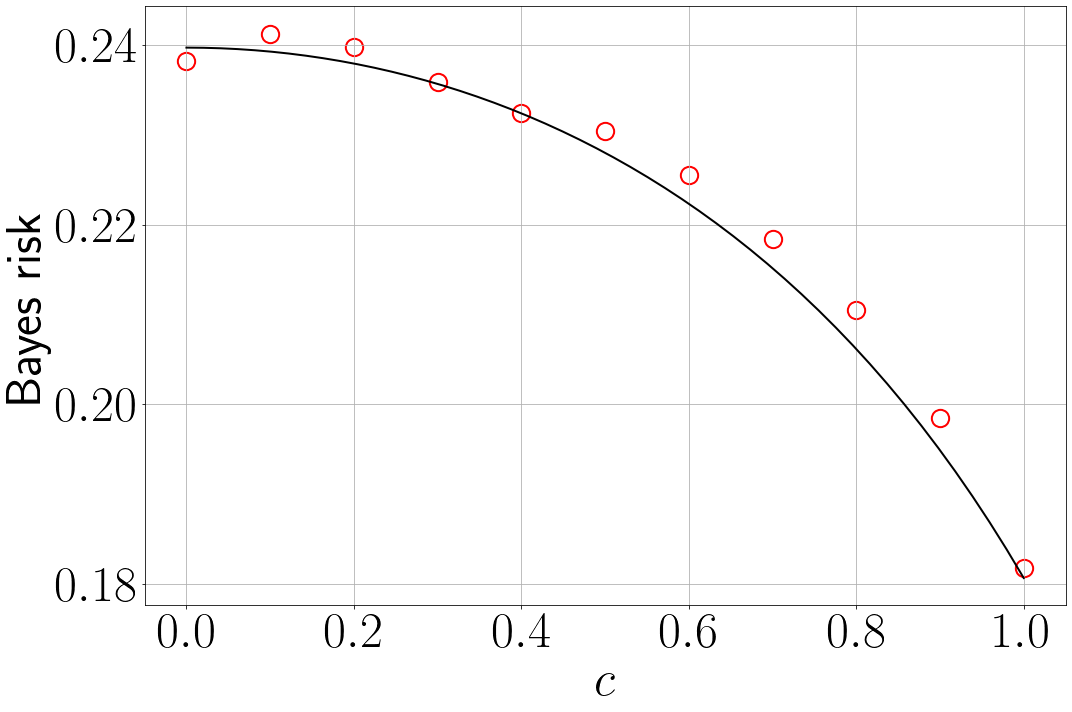

In [204]:
width = 15
height = 10
big = int(width/15*50) # if width of the figure is 15, then fontsize 50 is the right choice
small = int(0.8*big) # small font
fig, ax = plt.subplots(figsize=(width, height), tight_layout=True)

ax.plot(c_th, r_th, linewidth=2, color = 'black')
ax.scatter(c_e, r_e, color = 'white', edgecolors= 'red', linewidth=2, s= 300)

ax.set_xlabel(r'$c$', fontsize=big)
ax.set_ylabel(r'Bayes risk', fontsize=big)
ax.tick_params(axis='both', labelsize=big)
ax.grid(True)
plt.savefig('optimal.pdf')

In [ ]:
Yb = np.array([V[t]@Y[t]/N[t] for t in range(T)]) # the 'average' vector of each task
Ce = Yb@Yb.T # estimate of C
sige = np.array([np.sqrt(al[t]*(Ce[t,t]-1)) for t in range(T)]) # estimate of sigmas